# Import modules and set paths

In [72]:
cd F:\UbuntuShare\sortProjects\171101\p1\glab

F:\UbuntuShare\sortProjects\171101\p1\glab


In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
import h5py as h5py
import glob as glob
import numpy as np
import scipy.io
import sys
import os
sys.path.append('C:\\Users\\Ginty\\Desktop\\DEV\\kwik-tools')
sys.path.append('C:\\Users\\Ginty\\Desktop\\DEV\\klusta')
sys.path.append('C://Users//Ginty//Desktop//DEV/PyWaveSurfer')
sys.path.append('C:\\Users\\Ginty\\Desktop\\DEV\\')
import klusta
from klusta.kwik import KwikModel
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import load_intan_input_channels as liic
import pandas as pd
from pywavesurfer import ws

In [74]:
currPath = os.getcwd()

# specify kwik file path and load model
#kwik_path = 'Z:/HarveyLab/Alan/Data/20170927/p1/p1.kwik'
#model = KwikModel(kwik_path)
# append kwik-tools path and import read_rhd
sys.path.append('C://Users/Alan/Documents/Github/clustering-pipelines')
import read_rhd as rhd

In [75]:
## import tool to read mda files; mlpy is available on the ms4 github branch (https://github.com/magland/mountainlab/tree/ms4)
ms4Path = 'C:\\Users\\Ginty\\Desktop\\DEV\\mountainlab\\packages\\pymountainsort\\mlpy' 
sys.path.append(ms4Path)
import mdaio

# Extract clusters in good category, analyze, and plot

In [76]:
firings = mdaio.readmda(currPath+'\\firings.curated.mda')
sampleRate = 20000

In [77]:
goodsamples = firings[1][:]
goodspikes = firings[2][:]
goodtimes = goodsamples/sampleRate

In [78]:
goodspikes

array([  8.,   8.,   8., ...,   9.,  19.,   9.])

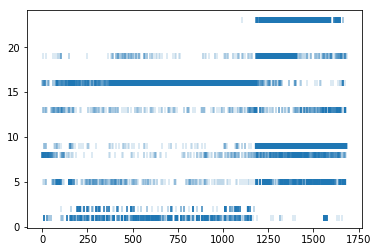

In [79]:
plt.plot(goodtimes, goodspikes,"|",mew=0.3)

In [80]:
import re
def load_intan_input_channels():
    #usage:  [di,ai] = load_intan_input_channels() with ai/di files in the path
    #save digital inputs
    p = re.compile('chan(\d+).di')  #extract digital input channel ids
    channel_ids = set(p.findall(' '.join(glob.glob('*.di'))))
    #load in each channel and concatenate.
    digital_inputs = {}
    for ch in channel_ids:
        files = glob.glob('*chan' + ch + '.di')
        files.sort(key=os.path.getmtime)
        for f in files:
            if ch in digital_inputs: #concatenation relies on os timestamp enforcing temporal order
                digital_inputs[ch] = np.append(digital_inputs[ch],(np.fromfile(f, dtype=np.uint32))) 
            else:  #load first array
                digital_inputs[ch] = np.fromfile(f, dtype=np.uint32)
    #save analog inputs
    p = re.compile('chan(\d+).ai')  #extract analog input channel ids
    channel_ids = set(p.findall(' '.join(glob.glob('*.ai'))))
    #load in each channel and concatenate.
    analog_inputs = {}
    for ch in channel_ids:
        files = glob.glob('*chan' + ch + '.ai')
        for f in files:
            if ch in analog_inputs: #load first array
                analog_inputs[ch] = np.append(analog_inputs[ch],(np.fromfile(f, dtype=np.float64)))  
            else:  #concatenation relies on alphabetical ordering corresponding to temporal order
                analog_inputs[ch] = np.fromfile(f, dtype=np.float64)
    return digital_inputs, analog_inputs

In [81]:
[di,ai] = load_intan_input_channels() # load traces from intan, break out into variables, and find trigger times

#these are hardware specific, replace integers with your own channel assigments
intan_trigger = di['0'][:]
intan_sync = di['1'][:]
intan_stim = di['2'][:]
intan_laser = di['3'][:]
intan_electrical = di['5'][:]
intan_puff = di['6'][:]
trig_sample =  np.where(intan_trigger[:-1] < intan_trigger[1:])[0]
electrical_sample =  np.where(intan_electrical[:-1] < intan_electrical[1:])[0]
laser_sample = np.where(intan_laser[:-1] < intan_laser[1:])[0]
trig_times = trig_sample / sampleRate
electrical_time = electrical_sample / sampleRate
laser_times = laser_sample/ sampleRate

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


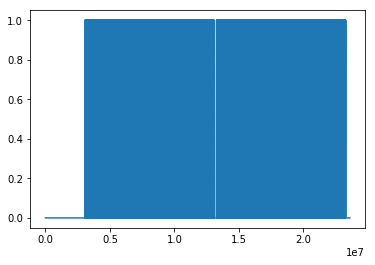

In [82]:
plt.plot(intan_laser[0:2.36e7])


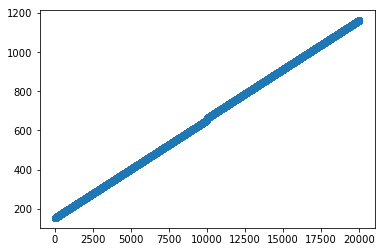

In [83]:
laser_times = [l for l in laser_times if l < 2.36e7 / sampleRate]
plt.plot(laser_times, 'o')


In [84]:
g = [(s,t) for (s,t) in zip(goodspikes,goodtimes) if s in [1.0,2.0,5.0]]
gspikes = [s for (s,t) in g]
gtimes = [t for (s,t) in g]

In [183]:

spike_detected_x = []
spike_detected_y = []

def plotClusterRF(clusters, cluster_num, spike_times, x_laser, y_laser, stim_times):
    for i,c in enumerate(clusters):
        if c == cluster_num:
            spike_delay = (spike_times[i] - stim_times[0]) % ((stim_times[1] - stim_times[0] - .0000045 ))
            if spike_delay < spike_window and spike_delay > spike_latency: 
                stim_index = int(np.round((spike_times[i] - stim_times[0]) / (stim_times[1] - stim_times[0] - .0000045 )))
                if (stim_times[stim_index] - spike_times[i]) > 0:
                    spike_detected_x.append(x_laser[stim_index])
                    spike_detected_y.append(y_laser[stim_index])
                    plt.plot(x_laser[stim_index], y_laser[stim_index], 'o')
    #plt.plot(spike_detected_x,spike_detected_y,'o')
    
def plotPSTH(clusters, cluster_num, spike_times, l_times):
    spikes = []
    timepoint = []
    for i,c in enumerate(clusters):
        if c == cluster_num:
            spike_delay = (spike_times[i] - l_times[0]) % (.0499996091)
            spikes.append(spike_delay)
            timepoint.append(spike_times[i])
    plt.plot(spikes, timepoint,'|')
    plt.ylim([np.min(spike_times), np.max(spike_times)])

    
def plotPSTH2(clusters, cluster_num, spike_times, l_times):
    spikes = []
    timepoint = []
    for i,c in enumerate(clusters):
        if c == cluster_num:
            if spike_times[i] > np.min(l_times) and spike_times[i] < np.max(l_times):
                nearest_laser_pulse = np.max([l for l in l_times if l < spike_times[i]])
                spike_delay = spike_times[i] - nearest_laser_pulse
                spikes.append(spike_delay)
                timepoint.append(spike_times[i])
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(spikes, timepoint,'|')
    plt.ylim([np.min(spike_times), np.max(spike_times)])
    plt.xlim([0.0,.05])
    plt.subplot(2,1,2)
    plt.hist(spikes, 4000)
    plt.xlim([0.0,.05])

1.0
2.0
5.0


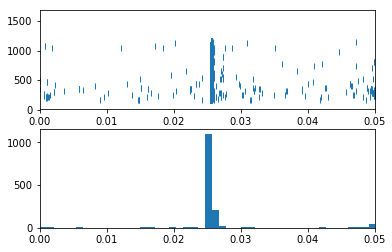

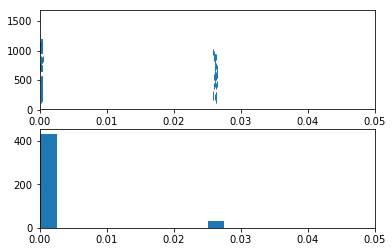

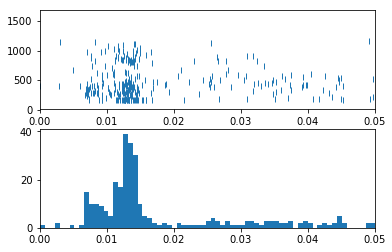

In [187]:
clusters = set(gspikes)
for c in clusters:
    print(c)
    plt.figure()
    plotPSTH2(gspikes, c, gtimes, laser_times)
    plt.savefig('psth.png')

In [87]:
cd C:\Users\Ginty\Desktop\DEV\touche\optohaptic\stimuli

C:\Users\Ginty\Desktop\DEV\touche\optohaptic\stimuli


In [165]:
from collections import defaultdict

def spike_detected(cluster_times, stim_time, spike_latency, spike_window):
    #print(stim_time)
    #print([t for (c,t) in cluster_times if t > stim_time])
    return [(c,t-stim_time) for (c,t) in cluster_times if (t > stim_time + spike_latency and t < stim_time + spike_window)]

def compute_optical_rf(cluster_times, laser_times, x_pos, y_pos):
    spike_latency = .010
    spike_window = .015
    spike_rfx = defaultdict(list)
    spike_rfy = defaultdict(list)
    spike_lat = defaultdict(list)
    
    for i,l in enumerate(laser_times):
        spikes = spike_detected(cluster_times, l, spike_latency, spike_window)
        for s,lat in spikes:
                spike_rfx[s].append(x_pos[i])
                spike_rfy[s].append(y_pos[i])
                spike_lat[s].append(lat)
    return spike_rfx, spike_rfy,spike_lat
            

In [166]:
x = pd.read_csv('6mmx11mmx50msecX',header=None)
x = x[0].tolist()
x = x + x[::-1]
y = pd.read_csv('6mmx11mmx50msecY',header=None)
y = y[0].tolist() 
y = y + y[::-1]

In [167]:
cluster_times = list(zip(gspikes, gtimes))
rfx,rfy,rfl = compute_optical_rf(cluster_times, laser_times[0:10000], x[0:10000], y[0:10000])
#rfx2,rfy2,rflat = compute_optical_rf(cluster_times, laser_times[10000:], x[10000:], y[10000:])

5.0
1.0


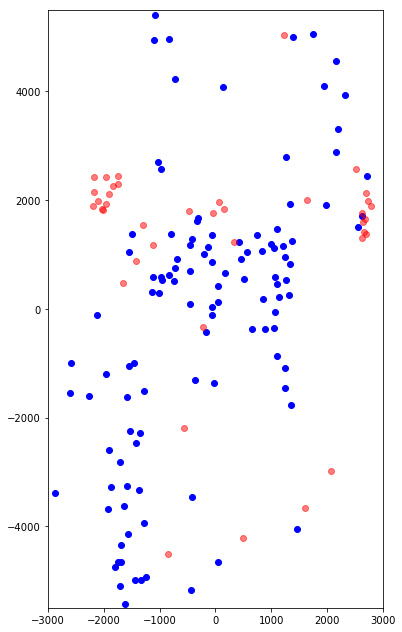

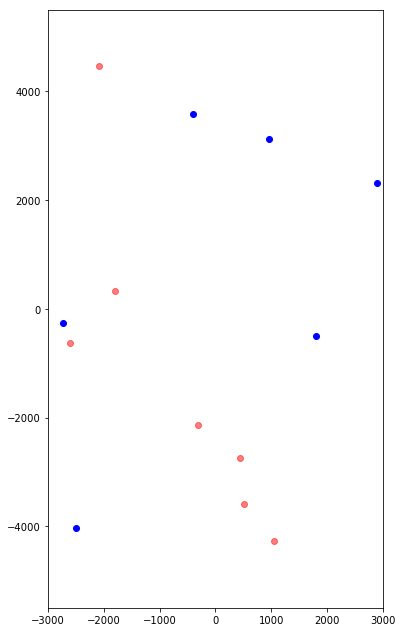

In [191]:

for cluster in rfx.keys():
    print (cluster)
    plt.figure(figsize=(6,11))
    plt.plot(rfx[cluster], rfy[cluster], 'o', color='b')
    plt.plot(rfxe[cluster], rfye[cluster], 'o', color = 'r', alpha=.5)
    plt.xlim([-3000,3000])
    plt.ylim([-5500,5500])
    plt.savefig(str(cluster) + 'rfmap.png')
#    plt.plot(rfx2[cluster], rfy2[cluster], 'o',color='b', alpha=0.7)

In [132]:
rgba_colors[:]

array([[ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.]])

In [8]:
fulloptical = ws.loadDataFile(filename='F:/UbuntuShare/171101/p1/glab/fo_0001-0003.h5', format_string='single' )

In [9]:
fulloptical['header']

{'AIChannelNames': array([b'force_cmd', b'displacement_cmd', b'force_in', b'displacement_in',
        b'strainbrush', b'y_mirror_in', b'x_mirror_in', b'fiber_photometry'], 
       dtype='|S16'), 'AITerminalIDsOnDevice': array([[  0.],
        [  1.],
        [  2.],
        [  3.],
        [  4.],
        [  5.],
        [  6.],
        [  7.],
        [ 16.],
        [ 17.],
        [ 18.],
        [ 19.],
        [ 20.],
        [ 21.],
        [ 22.],
        [ 23.]]), 'AOChannelNames': array([b'x_mirror', b'force', b'displacement', b'y_mirror'], 
       dtype='|S12'), 'AbsoluteProtocolFileName': array([b'C:\\Users\\Ginty Lab\\Desktop\\waveSurferProtocols\\IntanBase.cfg'], 
       dtype='|S60'), 'AbsoluteUserSettingsFileName': array([b''], dtype=object), 'Acquisition': {'ActiveChannelIndexFromChannelIndex': array([[  1.],
         [  2.],
         [  3.],
         [  4.],
         [  5.],
         [  6.],
         [  7.],
         [  8.],
         [  9.],
         [ 10.],
         [

KeyboardInterrupt: 

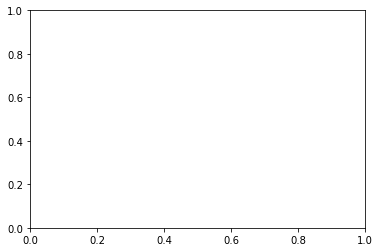

In [92]:
plt.plot(fulloptical['sweep_0001']['digitalScans'][0:100000])

In [38]:
np.max(fulloptical['sweep_0001']['analogScans'][6])

0.50825119

In [ ]:
def get_cluster_waveforms (kwik_model,cluster_id):
    try:
        if (not(type(kwik_model) is KwikModel)):
            raise ValueError       
    except ValueError:
            print ("Exception: the first argument should be a KwikModel object")
            return
        
    clusters = kwik_model.spike_clusters
    try:
        if ((not(cluster_id in clusters))):
            raise ValueError       
    except ValueError:
            print ("Exception: cluster_id (%d) not found !! " % cluster_id)
            return
    
    idx=np.argwhere (clusters==cluster_id)
    w=model.all_waveforms[idx]
    return w

def plot_cluster_waveforms (kwik_model,cluster_id,nspikes, save=False,save_path=None):
    
    w = get_cluster_waveforms (kwik_model,cluster_id)
    y_off = max(model.channel_positions[:,1])
    y_scale = 1
    x_scale = 1
    num_channels = w.shape[2]
    waveform_size = w.shape[1]
    np.random.seed()
    
    fig=plt.figure(num=None, figsize=(2, 4), facecolor='w', edgecolor='k')
    plt.clf()
    spike_id = np.arange(w.shape[0])
    np.random.shuffle(spike_id)
    spike_id = spike_id[0:nspikes]
    for ch in range (0,num_channels):
        x_offset = model.channel_positions [ch,0]
        y_offset = model.channel_positions [ch,1]*y_scale-y_off
        mu_spikes = np.mean(w[:,:,ch],0)
        for i in spike_id:
            spike = w[i,:,ch]
            x=x_scale*x_offset+range(int(-waveform_size/2),int(waveform_size/2))
            #plt.plot (x,0.05*spike+y_offset,color="gray",alpha=0.5)
        plt.plot (x,0.3*mu_spikes+y_offset,"-",color="black",linewidth=1,alpha=0.5)
    plt.ylabel('microns')
    plt.xlabel('microns')
    plt.tight_layout()
    plt.show()
    if (save):
        if (save_path):
            filename = "%s/waveform_%02d.png" % (save_path,cluster_id)
        else:
            filename = "waveform_%02d.png" % cluster_id
        fig.savefig (filename,dpi=300)

In [ ]:
for i, cluster in enumerate(good):
    print(cluster,'=', i,':')
    plot_cluster_waveforms(model,cluster,1000,save=False)